In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.integrate import cumtrapz

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

# surpress warnings
import warnings
warnings.filterwarnings("ignore")

# train data
train_features = pd.read_csv('../data/dengue_features_train.csv')
labels = pd.read_csv('../data/dengue_labels_train.csv')
train_features['total_cases'] = labels['total_cases']
print(train_features.shape)

# test data
test_features = pd.read_csv('../data/dengue_features_test.csv')
print(test_features.shape)

# separate train and test features for the two cities
sj = train_features[train_features.city=='sj'].copy()
sjtest = test_features[test_features.city=='sj'].copy()
iq = train_features[train_features.city=='iq'].copy()
iqtest = test_features[test_features.city=='iq'].copy()

train_features.shape

(1456, 25)
(416, 24)


(1456, 25)

In [2]:
train_features

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1


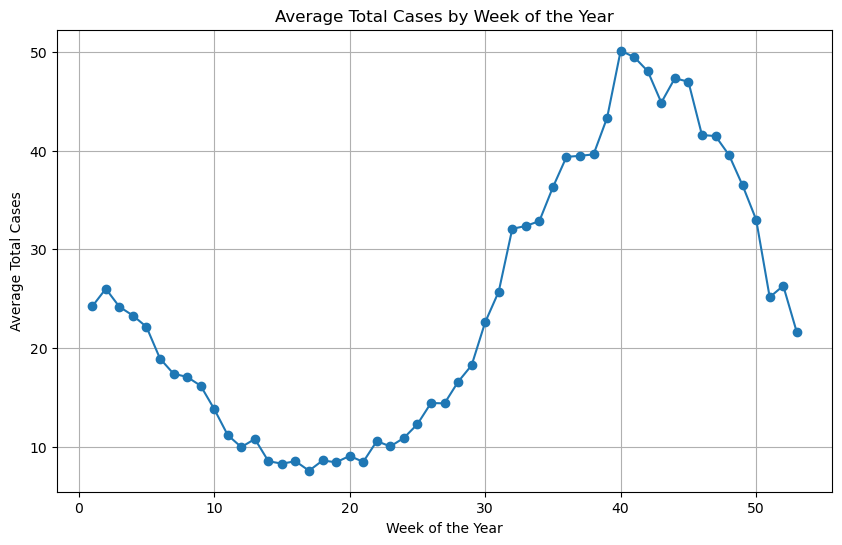

In [5]:
import matplotlib.pyplot as plt

# Group data by weekofyear and calculate the mean total_cases
weekly_cases = train_features.groupby('weekofyear')['total_cases'].mean()

# Plot the line graph
plt.figure(figsize=(10, 6))
plt.plot(weekly_cases.index, weekly_cases.values, marker='o')
plt.title('Average Total Cases by Week of the Year')
plt.xlabel('Week of the Year')
plt.ylabel('Average Total Cases')
plt.grid()
plt.show()

In [7]:
# processes san juan dataset
def process_sj(features):
    # cycle weeks exceeding 52 to 1
    features.loc[:,'weekofyear'] = np.where(features.weekofyear>52,1, features.weekofyear)
    
    # fill nulls with interpolation
    feats = features.interpolate(method='linear')

    # add features for case fluctuation seasons
    cutoffs = [10, 29]
    # cases begin to fall from weeks 0 to 10
    feats['fall'] = np.where((feats.weekofyear<=cutoffs[0]), 1, 0)
    # case numbers remain low and do not fluctuate much from weeks 11 to 29
    feats['low'] = np.where((feats.weekofyear>cutoffs[0]) & (feats.weekofyear<=cutoffs[1]), 1, 0)
    # case numbers spike from week 29 onward
    feats['spike'] = np.where((feats.weekofyear>=cutoffs[1]), 1, 0)
    
    # scale and average temperature readings using minmax scaler
    tempscols_to_average = feats.loc[:,['reanalysis_max_air_temp_k', 'station_avg_temp_c',
       'reanalysis_avg_temp_k', 'reanalysis_min_air_temp_k',
       'station_min_temp_c', 'reanalysis_dew_point_temp_k',
       'reanalysis_air_temp_k']]
    scaled_temps = pd.DataFrame(MinMaxScaler().fit_transform(tempscols_to_average), columns=tempscols_to_average.columns)
    feats.loc[:,'temps_mean'] = scaled_temps.mean(axis=1)
    
    # add interaction terms
    interaction_features = ['station_max_temp_c', 'temps_mean', 'reanalysis_relative_humidity_percent', 'reanalysis_specific_humidity_g_per_kg']
    for i,feature1 in enumerate(interaction_features):
        for feature2 in interaction_features[i+1:]:
            #print(f'{feature1}_x_{feature2}')
            feats[f'{feature1}_x_{feature2}'] = feats[feature1]*feats[feature2]
    
    # drop unneeded columns
    cols = ['total_cases', 'fall', 'low', 'spike', 'weekofyear',
            'station_max_temp_c','temps_mean', 'reanalysis_relative_humidity_percent',
            'reanalysis_specific_humidity_g_per_kg','reanalysis_precip_amt_kg_per_m2', 'station_max_temp_c_x_temps_mean', 
            'station_max_temp_c_x_reanalysis_relative_humidity_percent', 'station_max_temp_c_x_reanalysis_specific_humidity_g_per_kg',
            'temps_mean_x_reanalysis_relative_humidity_percent', 'temps_mean_x_reanalysis_specific_humidity_g_per_kg',
            'reanalysis_relative_humidity_percent_x_reanalysis_specific_humidity_g_per_kg'
           ]
    for col in feats.columns:
        if col not in cols:
            feats = feats.drop(col, axis=1)
            
    # add lag features
    to_shift = ['station_max_temp_c', 'temps_mean','reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg','reanalysis_precip_amt_kg_per_m2'] 
    for i in to_shift:
        feats[i+'_1lag'] = feats[i].shift(-1)
        feats[i+'_2lag'] = feats[i].shift(-2)
    
    # fill any leftover null values using forward fill
    feats = feats.fillna(method='ffill')
    
    # return processed features
    return feats

In [9]:
sj = process_sj(sj)
sj.shape

(936, 26)

In [11]:
sj

,weekofyear,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,station_max_temp_c,total_cases,fall,low,spike,temps_mean,...,station_max_temp_c_1lag,station_max_temp_c_2lag,temps_mean_1lag,temps_mean_2lag,reanalysis_relative_humidity_percent_1lag,reanalysis_relative_humidity_percent_2lag,reanalysis_specific_humidity_g_per_kg_1lag,reanalysis_specific_humidity_g_per_kg_2lag,reanalysis_precip_amt_kg_per_m2_1lag,reanalysis_precip_amt_kg_per_m2_2lag
0,18,32.00,73.365714,14.012857,29.4,4,0,1,0,0.324516,...,31.7,32.2,0.481929,0.551015,77.368571,82.052857,15.372857,16.848571,17.94,26.10
1,19,17.94,77.368571,15.372857,31.7,5,0,1,0,0.481929,...,32.2,33.3,0.551015,0.599826,82.052857,80.337143,16.848571,16.672857,26.10,13.90
2,20,26.10,82.052857,16.848571,32.2,4,0,1,0,0.551015,...,33.3,35.0,0.599826,0.692043,80.337143,80.460000,16.672857,17.210000,13.90,12.20
3,21,13.90,80.337143,16.672857,33.3,3,0,1,0,0.599826,...,35.0,34.4,0.692043,0.703828,80.460000,79.891429,17.210000,17.212857,12.20,26.49
4,22,12.20,80.460000,17.210000,35.0,6,0,1,0,0.692043,...,34.4,32.2,0.703828,0.624785,79.891429,82.000000,17.212857,17.234286,26.49,38.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,13,7.55,74.247143,13.644286,30.0,4,0,1,0,0.267055,...,30.6,29.4,0.429826,0.334942,74.600000,75.027143,14.662857,14.184286,3.67,35.00
932,14,3.67,74.600000,14.662857,30.6,3,0,1,0,0.429826,...,29.4,29.4,0.334942,0.350606,75.027143,72.285714,14.184286,13.858571,35.00,4.82
933,15,35.00,75.027143,14.184286,29.4,1,0,1,0,0.334942,...,29.4,31.7,0.350606,0.520972,72.285714,76.960000,13.858571,15.671429,4.82,2.17
934,16,4.82,72.285714,13.858571,29.4,3,0,1,0,0.350606,...,31.7,31.7,0.520972,0.520972,76.960000,76.960000,15.671429,15.671429,2.17,2.17


In [13]:
# x,y split
sj_X = sj.drop(['total_cases'], axis=1)
sj_y = sj.total_cases

# train test split for san juan data
X_train_sj, X_test_sj, y_train_sj, y_test_sj = train_test_split(
    sj_X, sj_y, test_size=0.3)
print(X_train_sj.shape)
print(X_test_sj.shape)

(655, 25)
(281, 25)


In [15]:
iq

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
936,iq,2000,26,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0
937,iq,2000,27,2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0
938,iq,2000,28,2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0
939,iq,2000,29,2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0
940,iq,2000,30,2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1


In [17]:
# training features for iquitos
iq = train_features[train_features.city=='iq'].copy()
print(iq.shape)

# preprocess iquitos data
def process_iq(features):
    # week numbers exceeding 52 are set back to 1 (cycles back to 1)
    features.loc[:,'weekofyear'] = np.where(features.weekofyear>52, 1, features.weekofyear)
        
    # fill nulls with linear interpolation
    feats = features.interpolate(method='linear')
            
    # add season features
    cutoffs = [12, 24, 36]
    feats['fall'] = np.where((feats.weekofyear<cutoffs[0]), 1, 0)
    feats['winter'] = np.where((feats.weekofyear>=cutoffs[0]) & (feats.weekofyear<cutoffs[1]), 1, 0)
    feats['spring'] = np.where((feats.weekofyear>=cutoffs[1]) & (feats.weekofyear<cutoffs[2]), 1, 0)
    feats['summer'] = np.where((feats.weekofyear>=cutoffs[2]), 1, 0)
    
     # add interaction terms
    interaction_features = ['station_avg_temp_c', 'reanalysis_min_air_temp_k',
                            'station_min_temp_c',
                            'reanalysis_specific_humidity_g_per_kg']
    for i, feature1 in enumerate(interaction_features):
        for feature2 in interaction_features[i+1:]:
            feats[f'{feature1}_x_{feature2}'] = feats[feature1] * feats[feature2]
            
    # drop unneeded columns
    keep = ['total_cases','spring', 'summer', 'fall', 'winter', 'station_avg_temp_c_x_reanalysis_min_air_temp_k',
            'station_avg_temp_c_x_station_min_temp_c', 'station_avg_temp_c_x_reanalysis_specific_humidity_g_per_kg',
            'reanalysis_min_air_temp_k_x_station_min_temp_c', 'reanalysis_min_air_temp_k_x_reanalysis_specific_humidity_g_per_kg',
            'station_min_temp_c_x_reanalysis_specific_humidity_g_per_kg', 'station_avg_temp_c','reanalysis_min_air_temp_k','station_min_temp_c',
            'reanalysis_dew_point_temp_k', 'reanalysis_tdtr_k','reanalysis_specific_humidity_g_per_kg','precipitation_amt_mm'
           ]
    for col in feats.columns:
        if col not in keep:
            feats = feats.drop(col, axis=1)
    
    # add lag features
    to_shift = ['station_avg_temp_c','reanalysis_min_air_temp_k', 'station_min_temp_c',
       'reanalysis_dew_point_temp_k', 'reanalysis_tdtr_k', 
       'reanalysis_specific_humidity_g_per_kg','precipitation_amt_mm']
    for i in to_shift:
        feats[i+'_1lag'] = feats[i].shift(-1)
        feats[i+'_2lag'] = feats[i].shift(-2)

    feats = feats.fillna(method='ffill')
    # return preprocessed features
    return feats
iq = process_iq(iq)
iq.shape

(520, 25)


(520, 32)

In [19]:
iq

,precipitation_amt_mm,reanalysis_dew_point_temp_k,reanalysis_min_air_temp_k,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_min_temp_c,total_cases,fall,winter,...,station_min_temp_c_1lag,station_min_temp_c_2lag,reanalysis_dew_point_temp_k_1lag,reanalysis_dew_point_temp_k_2lag,reanalysis_tdtr_k_1lag,reanalysis_tdtr_k_2lag,reanalysis_specific_humidity_g_per_kg_1lag,reanalysis_specific_humidity_g_per_kg_2lag,precipitation_amt_mm_1lag,precipitation_amt_mm_2lag
936,25.41,295.184286,293.1,16.651429,8.928571,26.400000,20.7,0,0,0,...,20.8,20.7,295.358571,295.622857,10.314286,7.385714,16.862857,17.120000,60.61,55.52
937,60.61,295.358571,291.1,16.862857,10.314286,26.900000,20.8,0,0,0,...,20.7,14.7,295.622857,292.797143,7.385714,9.114286,17.120000,14.431429,55.52,5.60
938,55.52,295.622857,292.6,17.120000,7.385714,26.800000,20.7,0,0,0,...,14.7,19.1,292.797143,293.957143,9.114286,9.500000,14.431429,15.444286,5.60,62.76
939,5.60,292.797143,288.6,14.431429,9.114286,25.766667,14.7,0,0,0,...,19.1,17.0,293.957143,291.725714,9.500000,13.771429,15.444286,13.421429,62.76,16.24
940,62.76,293.957143,291.5,15.444286,9.500000,26.600000,19.1,0,0,0,...,17.0,19.9,291.725714,293.821429,13.771429,11.471429,13.421429,15.311429,16.24,89.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,55.30,296.825714,294.5,18.485714,9.800000,28.633333,22.4,5,0,1,...,21.7,19.2,296.452857,295.501429,7.471429,7.500000,18.070000,17.008571,86.47,58.94
1452,86.47,296.452857,291.9,18.070000,7.471429,27.433333,21.7,8,0,1,...,19.2,21.0,295.501429,295.324286,7.500000,7.871429,17.008571,16.815714,58.94,59.67
1453,58.94,295.501429,292.4,17.008571,7.500000,24.400000,19.2,1,0,1,...,21.0,22.2,295.324286,295.807143,7.871429,11.014286,16.815714,17.355714,59.67,63.22
1454,59.67,295.324286,291.9,16.815714,7.871429,25.433333,21.0,1,0,0,...,22.2,22.2,295.807143,295.807143,11.014286,11.014286,17.355714,17.355714,63.22,63.22


In [21]:
# iquitos x and y
iq_X = iq.drop(['total_cases'], axis=1)
iq_y = iq.total_cases

# train test split for iquitos data
X_train_iq, X_test_iq, y_train_iq, y_test_iq = train_test_split(
    iq_X, iq_y, test_size=0.3)
print(X_train_iq.shape)
print(X_test_iq.shape)

(364, 31)
(156, 31)


In [23]:
# define random forest regression parameters we want to grid search on
param_grid = {
    'max_depth': [5,10,20,35,50],
    'max_features': [2, 5, 'auto'],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [100, 200, 300],
}
rfr = RandomForestRegressor(criterion='absolute_error')
gs = GridSearchCV(estimator=rfr, param_grid=param_grid,cv=3, n_jobs=-1)

# fit grid search to data for sj
gs.fit(X_train_sj, y_train_sj)
# get best parameters
sj_rf_params = gs.best_params_

sj_rf_params

{'max_depth': 50,
 'max_features': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [24]:
rfr = RandomForestRegressor(criterion='absolute_error')
gs = GridSearchCV(estimator=rfr, param_grid=param_grid,cv=3, n_jobs=-1)
# fit grid search to data for iq
gs.fit(X_train_iq, y_train_iq)
# find best params using grid search
iq_rf_params = gs.best_params_

iq_rf_params

{'max_depth': 20,
 'max_features': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [25]:
# initialize and train random forest regressor using best params
sj_rfr = RandomForestRegressor(**sj_rf_params, criterion='absolute_error')
iq_rfr = RandomForestRegressor(**iq_rf_params, criterion='absolute_error')
sj_rfr.fit(sj_X, sj_y)
iq_rfr.fit(iq_X, iq_y)
print('Training complete!')

Training complete!


In [26]:
test = pd.read_csv('../data/dengue_features_test.csv')
# san juan data from test dataset
sj_test = test[test.city=='sj'].copy()
# preprocess test data
sj_test = process_sj(sj_test)
sj_test.shape
(260, 23)

# iquitos data from test dataset
iq_test = test[test.city=='iq'].copy()
iq_test = process_iq(iq_test)
iq_test.shape
(156, 32)

# get predictions using random forest regressor
sj_pred = sj_rfr.predict(sj_test).astype(int)
iq_pred = iq_rfr.predict(iq_test).astype(int)

# confirm that there are no negative predictions
print(np.min(sj_pred))
print(np.min(iq_pred))

7
1


In [27]:
submission = pd.read_csv('../data/submission_format.csv', index_col=[0, 1, 2])
submission.total_cases = np.concatenate([sj_pred, iq_pred])
submission.to_csv("submission.csv")

In [28]:
# extract a test set from training for sj
test_sj = sj.sample(n=260, random_state=42)
X_test_sj = test_sj.drop(labels = ['total_cases'], axis = 1, inplace= False)

test_sj

,weekofyear,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,station_max_temp_c,total_cases,fall,low,spike,temps_mean,...,station_max_temp_c_1lag,station_max_temp_c_2lag,temps_mean_1lag,temps_mean_2lag,reanalysis_relative_humidity_percent_1lag,reanalysis_relative_humidity_percent_2lag,reanalysis_specific_humidity_g_per_kg_1lag,reanalysis_specific_humidity_g_per_kg_2lag,reanalysis_precip_amt_kg_per_m2_1lag,reanalysis_precip_amt_kg_per_m2_2lag
321,27,23.90,80.061429,17.211429,32.2,4,0,1,0,0.674812,...,32.8,31.1,0.690809,0.619925,81.835714,84.322857,17.764286,17.538571,35.23,123.20
70,36,42.33,82.310000,18.262857,34.4,64,0,0,1,0.769591,...,33.9,33.3,0.782164,0.814282,78.627143,80.877143,17.895714,18.400000,11.40,28.80
209,18,14.10,80.352857,16.621429,33.3,22,0,1,0,0.583846,...,31.7,33.3,0.564769,0.557334,80.462857,83.135714,16.280000,16.767143,21.10,28.90
656,50,7.45,74.517143,16.327143,30.0,9,0,0,1,0.599680,...,30.6,29.4,0.554193,0.505466,74.942857,79.482857,15.918571,16.160000,8.30,19.70
685,27,5.80,78.928571,17.744286,32.8,11,0,1,0,0.763402,...,31.7,31.7,0.704918,0.675075,79.658571,79.744286,17.487143,17.724286,44.04,21.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,38,33.83,82.332857,18.847143,34.4,54,0,0,1,0.818707,...,32.2,32.8,0.755850,0.776242,83.331429,78.782857,18.581429,18.061429,55.80,124.40
601,47,18.90,79.861429,16.972857,31.1,72,0,0,1,0.626449,...,29.4,31.1,0.550468,0.380610,74.344286,74.038571,15.414286,14.771429,7.81,13.20
409,11,42.78,80.778571,16.081429,32.2,34,0,1,0,0.450140,...,28.9,31.1,0.380784,0.484347,72.642857,76.675714,14.367143,15.480000,0.60,21.00
770,7,5.30,72.245714,12.807143,26.7,12,1,0,0,0.107505,...,27.2,30.6,0.211918,0.320766,74.191429,78.667143,13.241429,14.750000,10.10,5.92


In [29]:
X_test_sj 

,weekofyear,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,station_max_temp_c,fall,low,spike,temps_mean,station_max_temp_c_x_temps_mean,...,station_max_temp_c_1lag,station_max_temp_c_2lag,temps_mean_1lag,temps_mean_2lag,reanalysis_relative_humidity_percent_1lag,reanalysis_relative_humidity_percent_2lag,reanalysis_specific_humidity_g_per_kg_1lag,reanalysis_specific_humidity_g_per_kg_2lag,reanalysis_precip_amt_kg_per_m2_1lag,reanalysis_precip_amt_kg_per_m2_2lag
321,27,23.90,80.061429,17.211429,32.2,0,1,0,0.674812,21.728934,...,32.8,31.1,0.690809,0.619925,81.835714,84.322857,17.764286,17.538571,35.23,123.20
70,36,42.33,82.310000,18.262857,34.4,0,0,1,0.769591,26.473924,...,33.9,33.3,0.782164,0.814282,78.627143,80.877143,17.895714,18.400000,11.40,28.80
209,18,14.10,80.352857,16.621429,33.3,0,1,0,0.583846,19.442080,...,31.7,33.3,0.564769,0.557334,80.462857,83.135714,16.280000,16.767143,21.10,28.90
656,50,7.45,74.517143,16.327143,30.0,0,0,1,0.599680,17.990397,...,30.6,29.4,0.554193,0.505466,74.942857,79.482857,15.918571,16.160000,8.30,19.70
685,27,5.80,78.928571,17.744286,32.8,0,1,0,0.763402,25.039590,...,31.7,31.7,0.704918,0.675075,79.658571,79.744286,17.487143,17.724286,44.04,21.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,38,33.83,82.332857,18.847143,34.4,0,0,1,0.818707,28.163534,...,32.2,32.8,0.755850,0.776242,83.331429,78.782857,18.581429,18.061429,55.80,124.40
601,47,18.90,79.861429,16.972857,31.1,0,0,1,0.626449,19.482575,...,29.4,31.1,0.550468,0.380610,74.344286,74.038571,15.414286,14.771429,7.81,13.20
409,11,42.78,80.778571,16.081429,32.2,0,1,0,0.450140,14.494501,...,28.9,31.1,0.380784,0.484347,72.642857,76.675714,14.367143,15.480000,0.60,21.00
770,7,5.30,72.245714,12.807143,26.7,1,0,0,0.107505,2.870387,...,27.2,30.6,0.211918,0.320766,74.191429,78.667143,13.241429,14.750000,10.10,5.92


In [30]:
# extract test set from training for iq
test_iq = iq.sample(n=156, random_state=42)
X_test_iq = test_iq.drop(labels = ['total_cases'], axis = 1, inplace = False)

test_iq

,precipitation_amt_mm,reanalysis_dew_point_temp_k,reanalysis_min_air_temp_k,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_min_temp_c,total_cases,fall,winter,...,station_min_temp_c_1lag,station_min_temp_c_2lag,reanalysis_dew_point_temp_k_1lag,reanalysis_dew_point_temp_k_2lag,reanalysis_tdtr_k_1lag,reanalysis_tdtr_k_2lag,reanalysis_specific_humidity_g_per_kg_1lag,reanalysis_specific_humidity_g_per_kg_2lag,precipitation_amt_mm_1lag,precipitation_amt_mm_2lag
1211,60.00,294.385714,293.2,15.915714,11.685714,28.500000,22.3,4,0,0,...,21.7,21.3,295.768571,295.802857,12.242857,8.642857,17.417143,17.364286,73.97,100.06
1029,109.49,296.310000,294.4,17.935714,6.728571,27.200000,20.3,18,0,1,...,21.7,21.2,296.631429,296.222857,7.314286,7.500000,18.222857,17.807143,45.59,60.05
942,89.37,293.821429,292.1,15.311429,11.471429,27.016667,19.9,0,0,0,...,20.5,19.0,293.992857,292.904286,13.700000,13.771429,15.465714,14.444286,42.08,49.22
1103,55.73,293.684286,288.2,15.311429,10.757143,27.800000,16.8,3,0,0,...,21.8,21.8,295.737143,295.828571,9.471429,11.600000,17.262857,17.451429,100.55,74.60
1026,110.42,296.108571,293.9,17.680000,4.400000,26.100000,20.7,5,0,1,...,20.2,20.8,296.741429,296.351429,6.185714,5.142857,18.395714,17.930000,94.01,75.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,111.06,294.520000,291.9,16.098571,11.971429,26.616667,21.0,1,0,0,...,21.0,21.8,291.092857,296.990000,13.000000,6.942857,13.188571,18.672857,3.90,59.11
953,49.25,294.708571,291.9,16.195714,13.457143,28.000000,20.0,0,0,0,...,21.1,21.5,295.274286,295.280000,13.328571,12.871429,16.868571,16.847143,67.64,51.83
1181,162.51,295.850000,291.9,17.398571,7.814286,28.700000,22.5,7,1,0,...,22.5,20.8,296.251429,296.088571,9.342857,7.628571,17.820000,17.624286,99.37,55.12
1002,58.75,293.812857,290.8,15.327143,11.342857,28.525000,21.8,0,0,0,...,20.0,21.0,294.214286,296.607143,12.885714,9.857143,15.872857,18.267143,77.89,77.15


In [31]:
X_test_iq

,precipitation_amt_mm,reanalysis_dew_point_temp_k,reanalysis_min_air_temp_k,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_min_temp_c,fall,winter,spring,...,station_min_temp_c_1lag,station_min_temp_c_2lag,reanalysis_dew_point_temp_k_1lag,reanalysis_dew_point_temp_k_2lag,reanalysis_tdtr_k_1lag,reanalysis_tdtr_k_2lag,reanalysis_specific_humidity_g_per_kg_1lag,reanalysis_specific_humidity_g_per_kg_2lag,precipitation_amt_mm_1lag,precipitation_amt_mm_2lag
1211,60.00,294.385714,293.2,15.915714,11.685714,28.500000,22.3,0,0,0,...,21.7,21.3,295.768571,295.802857,12.242857,8.642857,17.417143,17.364286,73.97,100.06
1029,109.49,296.310000,294.4,17.935714,6.728571,27.200000,20.3,0,1,0,...,21.7,21.2,296.631429,296.222857,7.314286,7.500000,18.222857,17.807143,45.59,60.05
942,89.37,293.821429,292.1,15.311429,11.471429,27.016667,19.9,0,0,1,...,20.5,19.0,293.992857,292.904286,13.700000,13.771429,15.465714,14.444286,42.08,49.22
1103,55.73,293.684286,288.2,15.311429,10.757143,27.800000,16.8,0,0,0,...,21.8,21.8,295.737143,295.828571,9.471429,11.600000,17.262857,17.451429,100.55,74.60
1026,110.42,296.108571,293.9,17.680000,4.400000,26.100000,20.7,0,1,0,...,20.2,20.8,296.741429,296.351429,6.185714,5.142857,18.395714,17.930000,94.01,75.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,111.06,294.520000,291.9,16.098571,11.971429,26.616667,21.0,0,0,0,...,21.0,21.8,291.092857,296.990000,13.000000,6.942857,13.188571,18.672857,3.90,59.11
953,49.25,294.708571,291.9,16.195714,13.457143,28.000000,20.0,0,0,0,...,21.1,21.5,295.274286,295.280000,13.328571,12.871429,16.868571,16.847143,67.64,51.83
1181,162.51,295.850000,291.9,17.398571,7.814286,28.700000,22.5,1,0,0,...,22.5,20.8,296.251429,296.088571,9.342857,7.628571,17.820000,17.624286,99.37,55.12
1002,58.75,293.812857,290.8,15.327143,11.342857,28.525000,21.8,0,0,0,...,20.0,21.0,294.214286,296.607143,12.885714,9.857143,15.872857,18.267143,77.89,77.15


In [32]:
from sklearn.metrics import mean_absolute_error as MAE
y_true_sj, y_pred_sj = test_sj['total_cases'], sj_rfr.predict(X_test_sj).astype(int)
print("Mean Absolute Error(MAE), San Juan: %f" %MAE(y_true_sj, y_pred_sj))

y_true_iq, y_pred_iq = test_iq['total_cases'], iq_rfr.predict(X_test_iq).astype(int)
print("Mean Absolute Error(MAE), Iquitos: %f" %MAE(y_true_iq, y_pred_iq))

Mean Absolute Error(MAE), San Juan: 12.519231
Mean Absolute Error(MAE), Iquitos: 3.762821


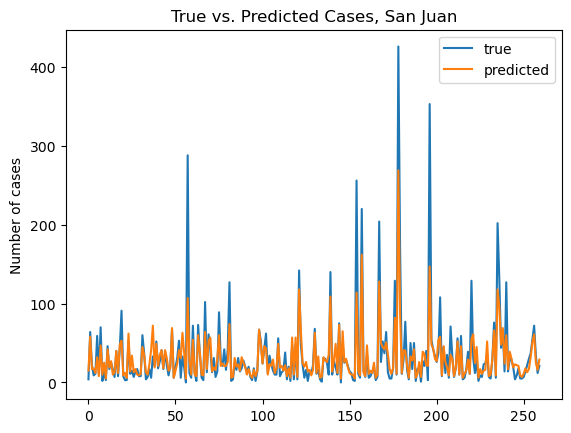

In [33]:
import matplotlib.pyplot as plt

plt.title('True vs. Predicted Cases, San Juan')
plt.plot(y_true_sj.tolist(), label = 'true')
plt.plot(y_pred_sj.tolist(), label = 'predicted')
plt.ylabel('Number of cases')
plt.legend()
plt.show()

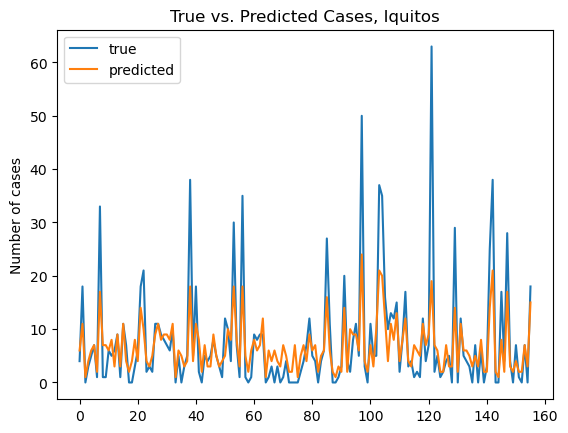

In [34]:
plt.title('True vs. Predicted Cases, Iquitos')
plt.plot(y_true_iq.tolist(), label = 'true')
plt.plot(y_pred_iq.tolist(), label = 'predicted')
plt.ylabel('Number of cases')
plt.legend()
plt.show()